In [1]:
# use geo_env_2022
import os
import numpy as np
import pandas as pd # original 1.2.3
import geopandas as gpd
from shapely.geometry import Point
import pickle
import urllib.request

import matplotlib.pyplot as plt

In [2]:
def get_prio_shape():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

    return prio_grid

In [3]:
def get_gwno():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno



In [4]:
def get_ucdp():
    location = '/home/simon/Documents/Bodies/data/UCDP' 
    path_ucdp = location + "/ged201-csv.zip"
    
    if os.path.isfile(path_ucdp) == True:
        print('file already downloaded')
        ucdp = pd.read_csv(path_ucdp)


    else: 
        print('Beginning file download UCDP...')

        url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    
        urllib.request.urlretrieve(url_ucdp, path_ucdp)
        ucdp = pd.read_csv(path_ucdp)

    return ucdp

In [5]:
def add_month_id(ucdp): # you could also do a week_id....

    ucdp_tmp1 = ucdp.copy()

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    ds_uniques = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7).unique()
    de_uniques = ucdp_tmp1['date_end'].str.slice(start = 0, stop = 7).unique() # do you need both?

    months_unique = np.union1d(ds_uniques, de_uniques)
    months_unique.sort()

    month_id = np.arange(109, months_unique.shape[0] + 109, 1) # this makes sure the month_id matches that of ViWES replication data. Just in case.

    month_df = pd.DataFrame({'month_id' : month_id, 'year_months_start' : months_unique, 'year_months_end' : months_unique})

    # I checked. There is no instance where the month id will differ if we take start or end.
    ucdp_tmp2 = ucdp_tmp1.merge(month_df[['month_id', 'year_months_start']], how = 'outer', on= 'year_months_start')

    return(ucdp_tmp2)

In [6]:
def trim_ucdp(ucdp_monthly):

    ucdp_slim = ucdp_monthly[['country','year', 'month_id', 'year_months_start', 'priogrid_gid','best','low','high']].copy()
    ucdp_gid = ucdp_slim.groupby(by=['priogrid_gid','month_id', 'year_months_start', 'year','country']).sum().reset_index() # so right now it is monthly units. you can change this..
    ucdp_gid.rename(columns={'priogrid_gid':'gid'}, inplace=True)

    ucdp_gid['log_best'] = np.log(ucdp_gid['best'] +1)
    ucdp_gid['log_low'] = np.log(ucdp_gid['low'] +1)
    ucdp_gid['log_high'] = np.log(ucdp_gid['high'] +1)

    return(ucdp_gid)

In [ ]:
def add_years(ucdp, world_grid):

    diff = ucdp['year'].max() - world_grid['year'].max()

    subset_list = []

    for i in np.arange(1, diff+1, 1):

        subset = world_grid[world_grid['year'] == world_grid['year'].max()].copy()
        subset['year'] = world_grid['year'].max() + i

        subset_list.append(subset)

    new_years = pd.concat(subset_list)
    world_grid_all_years = pd.concat([world_grid, new_years])

    return world_grid_all_years

In [ ]:
def combine_UCDP_PRIO(ucdp_gid, world_grid_all_years):

    month = [str(i).zfill(2) for i in np.arange(1,13,1)]
    world_grid_all_years.loc[:,'month'] = world_grid_all_years.apply(lambda _: month, axis=1)
    world_grid_monthly = world_grid_all_years.explode('month')

    world_grid_monthly['year_months_start'] = world_grid_monthly['year'].astype(str) + '-' +  world_grid_monthly['month'].astype(str)

    #ucdp_cliped = ucdp_gid[ucdp_gid['year']<2015].copy()# Could also just expand world_grid_monhtly but I do not need these values anyway (for now)..

    combined_df = world_grid_monthly.merge(ucdp_gid, how = 'left', on = ['gid', 'year_months_start', 'year']) # month id needs to be made after..
    combined_df.loc[:, ['best', 'low', 'high', 'log_best', 'log_low', 'log_high']] = combined_df.loc[:, ['best', 'low', 'high', 'log_best', 'log_low', 'log_high']].fillna(0)

    month_id_dict = dict(zip(ucdp_gid['year_months_start'],ucdp_gid['month_id']))
    combined_df['month_id'].fillna(combined_df['year_months_start'].map(month_id_dict), inplace = True)
    combined_df['month_id'] = combined_df['month_id'].astype(int)

    #combined_df['gwno'] = combined_df['gwno'].astype(int)
    # Does not really work...
    #contry_dict = dict(zip(combined_df.loc[combined_df['country'].notna(), 'country'].unique(), combined_df.loc[combined_df['country'].notna(), 'gwno'].unique()))
    #combined_df['country'].fillna(combined_df['gwno'].map(contry_dict), inplace = True)

    combined_df.drop(columns= ['country'], inplace = True)

    return(combined_df)

In [7]:
prio_grid = get_prio_shape()
gwno = get_gwno()
world_grid = prio_grid.merge(gwno, how = 'right', on = 'gid')

ucdp = get_ucdp()
ucdp_monthly = add_month_id(ucdp)
ucdp_gid = trim_ucdp(ucdp_monthly)

world_grid_all_years = add_years(ucdp, world_grid)

combined_df = combine_UCDP_PRIO(ucdp_gid, world_grid_all_years)

File already downloaded
file already downloaded


/tmp/ipykernel_185656/3991126561.py:7: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv(path_ucdp)


In [ ]:
# Check:

for y in sorted(combined_df['year'].unique()):
    array = combined_df[combined_df['year'] == y]['month_id'].unique()
    print(f'{y}: {array}')

for y in sorted(ucdp_gid['year'].unique())[:26]:
    array = sorted(ucdp_gid[ucdp_gid['year'] == y]['month_id'].unique())
    print(f'{y}: {array}')

In [41]:
combined_df

,gid,xcoord,ycoord,col,row,geometry,year,gwno,month,year_months_start,month_id,best,low,high,log_best,log_low,log_high
0,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,01,2003-01,277,0.0,0.0,0.0,0.0,0.0,0.0
1,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,02,2003-02,278,0.0,0.0,0.0,0.0,0.0,0.0
2,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,03,2003-03,279,0.0,0.0,0.0,0.0,0.0,0.0
3,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,04,2003-04,280,0.0,0.0,0.0,0.0,0.0,0.0
4,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,05,2003-05,281,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20223556,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",1994,20.0,08,1994-08,176,0.0,0.0,0.0,0.0,0.0,0.0
20223557,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",1994,20.0,09,1994-09,177,0.0,0.0,0.0,0.0,0.0,0.0
20223558,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",1994,20.0,10,1994-10,178,0.0,0.0,0.0,0.0,0.0,0.0
20223559,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",1994,20.0,11,1994-11,179,0.0,0.0,0.0,0.0,0.0,0.0


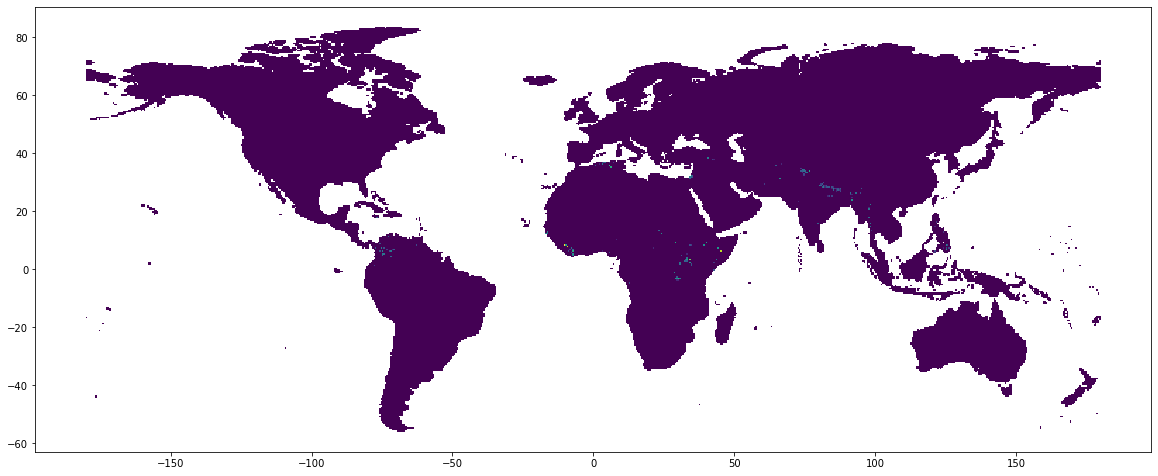

In [42]:
fig, ax = plt.subplots(figsize = (20,20))
combined_df[combined_df['month_id'] == 277].plot(ax=ax, column = 'log_best')
plt.show()

In [80]:
combined_df[combined_df['year'] == 1999]['month_id'].unique()

array([229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240])

In [31]:
combined_df['year_months_start'].unique().shape

(312,)

In [32]:
ucdp_cliped['year_months_start'].unique().shape

(312,)

In [25]:
ucdp_cliped['month_id'].map(month_id_dict)

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
         ..
82649   NaN
82651   NaN
82653   NaN
82654   NaN
82655   NaN
Name: month_id, Length: 61216, dtype: float64

In [24]:
month_id_dict

{'1992-03': 147,
 '1994-07': 175,
 '1989-09': 117,
 '1991-03': 135,
 '1991-06': 138,
 '1991-08': 140,
 '1991-10': 142,
 '1992-02': 146,
 '1992-07': 151,
 '1994-10': 178,
 '1994-11': 179,
 '1996-03': 195,
 '1996-09': 201,
 '1996-11': 203,
 '1997-03': 207,
 '1997-04': 208,
 '1998-08': 224,
 '1999-01': 229,
 '1992-08': 152,
 '1992-12': 156,
 '1993-07': 163,
 '1990-01': 121,
 '1991-01': 133,
 '1991-07': 139,
 '1991-11': 143,
 '1993-08': 164,
 '1993-12': 168,
 '1999-03': 231,
 '2002-06': 270,
 '1990-09': 129,
 '1991-02': 134,
 '1994-01': 169,
 '1998-09': 225,
 '1990-07': 127,
 '1996-01': 193,
 '1996-04': 196,
 '1996-05': 197,
 '1996-07': 199,
 '1996-10': 202,
 '1997-05': 209,
 '1997-08': 212,
 '1998-07': 223,
 '1998-10': 226,
 '1998-11': 227,
 '1993-03': 159,
 '1993-04': 160,
 '1990-08': 128,
 '1993-05': 161,
 '1989-07': 115,
 '1990-10': 130,
 '1993-02': 158,
 '1992-11': 155,
 '1993-09': 165,
 '1994-03': 171,
 '1989-12': 120,
 '1993-10': 166,
 '1991-12': 144,
 '1989-10': 118,
 '1990-02': 12

In [22]:
ucdp_cliped[['year_months_start', 'month_id']].to_dict()

{'year_months_start': {1: '1992-03',
  2: '1994-07',
  3: '1989-09',
  4: '1991-03',
  5: '1991-06',
  6: '1991-08',
  7: '1991-10',
  8: '1992-02',
  9: '1992-07',
  10: '1994-10',
  11: '1994-11',
  12: '1996-03',
  13: '1996-09',
  14: '1996-11',
  15: '1997-03',
  16: '1997-04',
  17: '1998-08',
  18: '1999-01',
  19: '1992-08',
  20: '1992-12',
  21: '1993-07',
  22: '1989-09',
  23: '1990-01',
  24: '1991-01',
  25: '1991-07',
  26: '1991-10',
  27: '1991-11',
  28: '1992-02',
  29: '1993-07',
  30: '1993-08',
  31: '1993-12',
  32: '1994-10',
  33: '1997-04',
  34: '1999-03',
  35: '2002-06',
  36: '1989-09',
  37: '1990-09',
  38: '1991-02',
  39: '1991-07',
  40: '1991-11',
  41: '1994-01',
  42: '1994-11',
  43: '1996-09',
  44: '1996-11',
  45: '1997-03',
  46: '1997-04',
  47: '1998-09',
  48: '1999-03',
  49: '1990-07',
  50: '1996-01',
  51: '1996-04',
  52: '1996-05',
  53: '1996-07',
  54: '1996-09',
  55: '1996-10',
  56: '1997-05',
  57: '1997-08',
  58: '1998-07',
  

In [ ]:
combined_df['month_id'].fillna()

KeyboardInterrupt: 

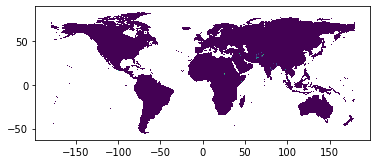

In [33]:
combined_df[combined_df['year'] == 2010].plot(column = 'log_best')

In [117]:
ucdp_gid['year'].max()

2019

In [99]:
world_grid_monthly['year'] + world_grid_monthly['month'].astype(str)

0         2009
0         2010
0         2011
0         2012
0         2013
          ... 
453725    2013
453725    2014
453725    2015
453725    2016
453725    2017
Length: 5444712, dtype: object

In [ ]:
world_grid

In [75]:
test_df.apply(lambda _: [1,2,3], axis=1)

0    [1, 2, 3]
1    [1, 2, 3]
2    [1, 2, 3]
3    [1, 2, 3]
4    [1, 2, 3]
dtype: object

In [78]:
test_df = pd.DataFrame({'year' : [1,2,3,4,5], 'value' : [34,544,23,23,43]})
test_df.loc[:,'month'] = test_df.apply(lambda _: [1,2,3], axis=1)
test_df.explode('month')

,year,value,month
0,1,34,1
0,1,34,2
0,1,34,3
1,2,544,1
1,2,544,2
1,2,544,3
2,3,23,1
2,3,23,2
2,3,23,3
3,4,23,1


<AxesSubplot:>

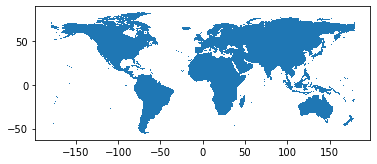

In [42]:
world_grid[world_grid['year'] == 2003].plot()

In [ ]:
def elong_df(df, df_w_time, temporal_unit):

    """While a bit hacky, this works. It extents the prio grid to match any temporal unit"""

    t = sorted(df_w_time[temporal_unit].unique())
    df[temporal_unit] = t[0]
    concat_df = df.copy()

    for i,j in enumerate(t[1:]):

        df_temp = df.copy()
        df_temp[temporal_unit] = j

        concat_df = pd.concat([concat_df, df_temp])
    
    concat_df.reset_index(inplace = True)
    return concat_df 

# Also old...

In [6]:
def get_exposure():
    pkl_file = open('/home/simon/Documents/Bodies/data/currents/currents_df.pkl', 'rb')

    exposure_df = pickle.load(pkl_file)
    pkl_file.close()

    return exposure_df

In [7]:
prio_grid = get_prio_shape()
exposure_df = get_exposure()

Beginning file download PRIO...


In [14]:
exposure_df.rename(columns = {'pg_id' : 'gid'}, inplace = True)

In [17]:
prio_grid_slim = prio_grid[['gid', 'xcoord', 'ycoord', 'geometry']].copy()
exposure_gdf = prio_grid_slim.merge(exposure_df, how = 'right', on = ['gid', 'xcoord', 'ycoord'])

<AxesSubplot:>

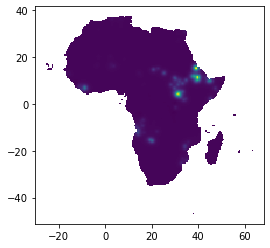

In [22]:
exposure_gdf[exposure_gdf['X'] == 121].plot(column = 'dce_mu')

# Old

In [24]:
def get_data(location):

    # Getting and loading views data
    print('Beginning file download UCDP...')

    url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    path_ucdp = location + "/ged201-csv.zip"
    urllib.request.urlretrieve(url_ucdp, path_ucdp)


    # Getting and loading prio data
    print('Beginning file download PRIO...')

    url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'
    path_prio = location + '/priogrid_shapefiles.zip'
    urllib.request.urlretrieve(url_prio, path_prio)

    # And move to correct location on computerome
    # gpd.read_file('zip://' + path_prio)
    prio_grid = gpd.read_file('zip://' + path_prio)
    ucdp = pd.read_csv(path_ucdp)

    return prio_grid, ucdp

In [25]:
prio_grid, ucdp = get_data(location)

Beginning file download UCDP...
Beginning file download PRIO...


/tmp/ipykernel_132377/2005915489.py:21: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv(path_ucdp)


In [26]:
# YOU NEED TO SAVE THIS FUNCTION SOMEWHERE

def add_month_id(ucdp = ucdp): # you could also do a week_id....

    ucdp_tmp1 = ucdp.copy()

    # debug
    # print(np.sort(ucdp_tmp1['year'].unique()))

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # check problem
    # ucdp_tmp1.loc[mask1 | mask2]

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    # see that it have been solved
    # ucdp_tmp1.loc[mask1 | mask2]

    # debug
    # print(np.sort(ucdp_tmp1['year'].unique()))

    # but do you need all years or just those in theb Bodies data?
    # tjeck woth views month id.. could be nice to just nail that now.

    ds_uniques = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7).unique()
    de_uniques = ucdp_tmp1['date_end'].str.slice(start = 0, stop = 7).unique() # do you need both?

    months_unique = np.union1d(ds_uniques, de_uniques)
    months_unique.sort()

    month_id = np.arange(109, months_unique.shape[0] + 109, 1) # this makes sure the month_id matches that of ViWES replication data. Just in case.

    month_df = pd.DataFrame({'month_id' : month_id, 'year_months_start' : months_unique, 'year_months_end' : months_unique})

    # I checked. There is no instance where the month id will differ if we take start or end.
    ucdp_tmp2 = ucdp_tmp1.merge(month_df[['month_id', 'year_months_start']], how = 'outer', on= 'year_months_start')
    #ucdp_tmp3 = ucdp_tmp2.merge(month_df[['month_id', 'year_months_end']], how = 'outer', on= 'year_months_end')
    #ucdp_tmp3[ucdp_tmp3['month_id_x'] == ucdp_tmp3['month_id_y']] # None


    ## just a test:

    # External
    # pkl_file = open('/media/simon/Seagate Backup Plus Drive/Articles/conflict_prediction/data/computerome/currents/preds_df_tt.pkl', 'rb')
    # currents_df = pickle.load(pkl_file)
    # pkl_file.close()

    # for y in np.sort(ucdp_tmp2['year'].unique())[1:29]:

    #     check = np.all(np.sort(ucdp_tmp2[ucdp_tmp2['year']==y]['month_id'].unique()) == currents_df[currents_df['year'] == y]['X'].unique())

    #     if check == False:

    #         print(f"{y}:{np.sort(ucdp_tmp2[ucdp_tmp2['year']==y]['month_id'].unique())}")
    #         print(f"{y}:{currents_df[currents_df['year'] == y]['X'].unique()}")
    #         print('\n')

    # it is cool.

    return(ucdp_tmp2)


In [27]:
ucdp_monthly =  add_month_id(ucdp = ucdp)


In [28]:
def trim_ucdp(ucdp = ucdp_monthly):

    ucdp_slim = ucdp[['country','year', 'month_id', 'priogrid_gid','best','low','high']]
    ucdp_gid = ucdp_slim.groupby(by=['priogrid_gid','month_id', 'year','country']).sum().reset_index() # so right now it is monthly units. you can change this..
    ucdp_gid.rename(columns={'priogrid_gid':'gid'}, inplace=True)

    ucdp_gid['log_best'] = np.log(ucdp_gid['best'] +1)
    ucdp_gid['log_low'] = np.log(ucdp_gid['low'] +1)
    ucdp_gid['log_high'] = np.log(ucdp_gid['high'] +1)

    return(ucdp_gid)

In [29]:
ucdp_gid = trim_ucdp(ucdp = ucdp_monthly)

In [30]:
ucdp_gid

,gid,month_id,year,country,best,low,high,log_best,log_low,log_high
0,75530,467,2018,Australia,2,2,2,1.098612,1.098612,1.098612
1,79444,147,1992,Argentina,0,0,29,0.000000,0.000000,3.401197
2,79444,175,1994,Argentina,86,86,86,4.465908,4.465908,4.465908
3,80318,117,1989,South Africa,1,1,2,0.693147,0.693147,1.098612
4,80318,135,1991,South Africa,1,1,1,0.693147,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...
82655,216561,292,2004,Russia (Soviet Union),5,5,5,1.791759,1.791759,1.791759
82656,216561,436,2016,Russia (Soviet Union),3,3,4,1.386294,1.386294,1.609438
82657,216561,437,2016,Russia (Soviet Union),3,3,3,1.386294,1.386294,1.386294
82658,216561,438,2016,Russia (Soviet Union),14,14,14,2.708050,2.708050,2.708050


In [31]:
prio_grid

,gid,xcoord,ycoord,col,row,geometry
0,259168,163.75,89.75,688,360,"POLYGON ((163.50000 89.50000, 163.50000 90.000..."
1,259169,164.25,89.75,689,360,"POLYGON ((164.00000 89.50000, 164.00000 90.000..."
2,259170,164.75,89.75,690,360,"POLYGON ((164.50000 89.50000, 164.50000 90.000..."
3,259171,165.25,89.75,691,360,"POLYGON ((165.00000 89.50000, 165.00000 90.000..."
4,259172,165.75,89.75,692,360,"POLYGON ((165.50000 89.50000, 165.50000 90.000..."
...,...,...,...,...,...,...
259195,43,-158.75,-89.75,43,1,"POLYGON ((-159.00000 -90.00000, -159.00000 -89..."
259196,44,-158.25,-89.75,44,1,"POLYGON ((-158.50000 -90.00000, -158.50000 -89..."
259197,45,-157.75,-89.75,45,1,"POLYGON ((-158.00000 -90.00000, -158.00000 -89..."
259198,46,-157.25,-89.75,46,1,"POLYGON ((-157.50000 -90.00000, -157.50000 -89..."


<AxesSubplot:>

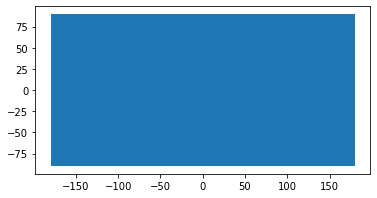

In [53]:
prio_grid.plot()

In [32]:
up_df = ucdp_gid.merge(prio_grid, how= 'outer', on = 'gid')
type(up_df)

pandas.core.frame.DataFrame

In [33]:
up_df

,gid,month_id,year,country,best,low,high,log_best,log_low,log_high,xcoord,ycoord,col,row,geometry
0,75530,467,2018,Australia,2,2,2,1.098612,1.098612,1.098612,144.75,-37.75,650,105,"POLYGON ((144.50000 -38.00000, 144.50000 -37.5..."
1,79444,147,1992,Argentina,0,0,29,0.000000,0.000000,3.401197,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5..."
2,79444,175,1994,Argentina,86,86,86,4.465908,4.465908,4.465908,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5..."
3,80318,117,1989,South Africa,1,1,2,0.693147,0.693147,1.098612,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000..."
4,80318,135,1991,South Africa,1,1,1,0.693147,0.693147,0.693147,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82655,216561,292,2004,Russia (Soviet Union),5,5,5,1.791759,1.791759,1.791759,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."
82656,216561,436,2016,Russia (Soviet Union),3,3,4,1.386294,1.386294,1.609438,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."
82657,216561,437,2016,Russia (Soviet Union),3,3,3,1.386294,1.386294,1.386294,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."
82658,216561,438,2016,Russia (Soviet Union),14,14,14,2.708050,2.708050,2.708050,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."


In [54]:
pu_df = prio_grid.merge(ucdp_gid, how = 'left', on = 'gid') # this way you keep it as as geopandas - but is that needed?
type(pu_df)

geopandas.geodataframe.GeoDataFrame

In [35]:
pu_df

,gid,xcoord,ycoord,col,row,geometry,month_id,year,country,best,low,high,log_best,log_low,log_high
0,75530,144.75,-37.75,650,105,"POLYGON ((144.50000 -38.00000, 144.50000 -37.5...",467,2018,Australia,2,2,2,1.098612,1.098612,1.098612
1,79444,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5...",147,1992,Argentina,0,0,29,0.000000,0.000000,3.401197
2,79444,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5...",175,1994,Argentina,86,86,86,4.465908,4.465908,4.465908
3,80318,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000...",117,1989,South Africa,1,1,2,0.693147,0.693147,1.098612
4,80318,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000...",135,1991,South Africa,1,1,1,0.693147,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82655,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",292,2004,Russia (Soviet Union),5,5,5,1.791759,1.791759,1.791759
82656,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",436,2016,Russia (Soviet Union),3,3,4,1.386294,1.386294,1.609438
82657,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",437,2016,Russia (Soviet Union),3,3,3,1.386294,1.386294,1.386294
82658,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",438,2016,Russia (Soviet Union),14,14,14,2.708050,2.708050,2.708050


**Really you need to have infered all coordinates before oyou get here...**

In [24]:
def get_bodies_data():    
    
    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}df_od_coordinates_full.pkl', 'rb') as file:
        bodies_df = pickle.load(file)

    return(bodies_df)

In [25]:
bodies_df = get_bodies_data()

In [28]:
bodies_df['year'].unique()

array(['2008', '2009', '2007', '2005', '2006', '2003', '2004', nan,
       '\x00\x03\x01\t\x00A\x00i\x00c\x00m\x00;\x00`\x00c\x00\x1c\x01\x02\x05|\x08t\x03\x00\x00\x00\x01\x00q\x00\x00\x00\x05\x05\x02`\x03#\x05\x01\x05\x0c\x13\x15M\x0f!\x08p\x02\x01>\x053\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x04\x00\x04h\n\x0e\x18\x01\x00d\x10 \x0f\x0fr\x00K\x00\x10\x1e\x10\x10\x0f\x19\x00\x1e\x00\x08\x00\x00\x10\x10S\x0f\x19\x00%\x00h\x0fv\x10'],
      dtype=object)

In [39]:
geometry = [Point(xy) for xy in zip(bodies_df['longitude_full'], bodies_df['latitude_full'])]
crs = {'init':'EPSG:4326'} #check that this is right!!!


# Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.
#Left CRS: +init=epsg:4326 +type=crs
#Right CRS: EPSG:4326


bodies_gdf = gpd.GeoDataFrame(bodies_df, crs = crs, geometry = geometry)

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [40]:
bodies_gdf

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,object name,latitude_p,longitude_p,date,location_annot,distance_days,pred_idx,longitude_full,latitude_full,geometry
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2008-12-27,0,0 days,184.0,44.378799,33.302431,POINT (44.37880 33.30243)
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2009-09-01,0,0 days,906.0,44.378799,33.302431,POINT (44.37880 33.30243)
2,1.6,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2007-10-12,0,0 days,582.0,44.378799,33.302431,POINT (44.37880 33.30243)
3,2.8,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2005-11-20,0,0 days,8226.0,41.037860,34.427567,POINT (41.03786 34.42757)
4,1.8,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2005-11-15,0,0 days,7896.0,41.046437,34.390889,POINT (41.04644 34.39089)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152436,0.6,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,34.376222,43.64465,2004-01-14,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)
152437,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,NaN,34.376222,43.64465,2004-01-15,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)
152438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,34.376222,43.64465,2004-01-15,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)
152439,4.8,5.0,5.0,5.0,5.0,5.0,4.0,1.5,1.5,2.0,...,NaN,34.376222,43.64465,2004-01-14,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)


In [114]:
# import contextily as ctx

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities.to_crs(bodies_gdf.crs)

# cities_mask = (cities['geometry'].x >25) & (cities['geometry'].x <45) & (cities['geometry'].y >28) & (cities['geometry'].y < 43)
cities_mask = ['Baghdad', 'Damascus', 'Amman', 'Ankara', 'Jerusalem', 'Beirut']

sub_cities = cities[cities['name'].isin(cities_mask)].copy()

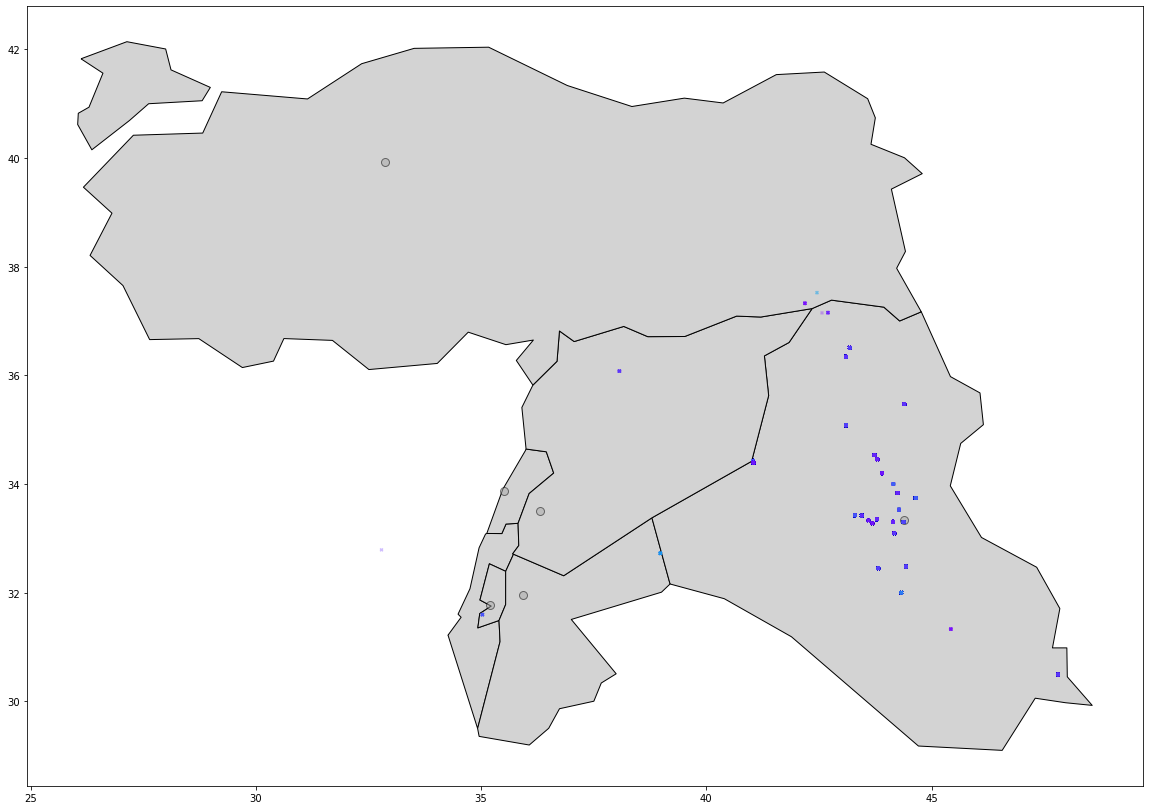

In [126]:
fig, ax = plt.subplots(figsize = (20,20))


# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.

ax.set_aspect('equal')

sub_world.plot(ax=ax, color='lightgray', edgecolor='black')
sub_cities.plot(ax=ax, marker='o', color='darkgray', edgecolor='black', markersize=64, alpha = 0.5)

bodies_gdf.plot(ax=ax, column = 'person_mean', marker='x', cmap = 'rainbow', markersize = 8, alpha = 0.3 )

path = '/home/simon/Documents/Bodies/figures/maps/'

#plt.savefig(path + '1606eks.pdf', bbox_inches = "tight")

#ax.figure.savefig(path + '1606eks.pdf', bbox_inches = "tight")


# fig = plt.gcf()
# fig.savefig(path + '1606eks.pdf', bbox_inches = "tight")

plt.show()

In [ ]:
plt.scatter()

<AxesSubplot:>

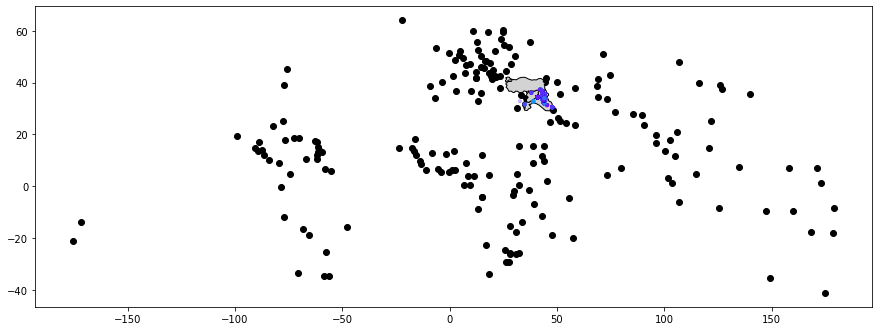

In [99]:
fig, ax = plt.subplots(figsize = (15,15))

#ax.set_aspect('equal') # don't know if this is relevant....

cities.plot(color = 'black', marker='o', ax=ax) 
sub_world.plot(color='lightgray', edgecolor='black', ax=ax)
bodies_gdf.plot(column = 'person_mean', marker='o', ax=ax, cmap = 'rainbow', markersize = 10, alpha = 0.3 )

<AxesSubplot:>

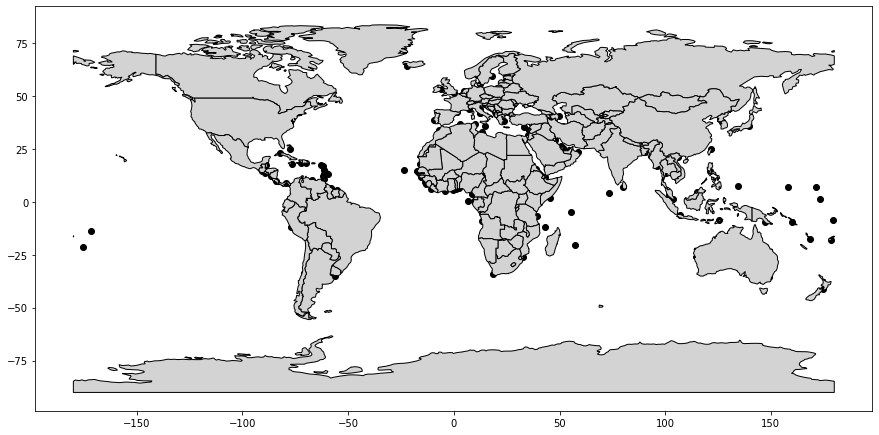

In [100]:
fig, ax = plt.subplots(figsize = (15,15))

#ax.set_aspect('equal') # don't know if this is relevant....

cities.plot(color = 'black', marker='o', ax=ax) 
world.plot(color='lightgray', edgecolor='black', ax=ax)

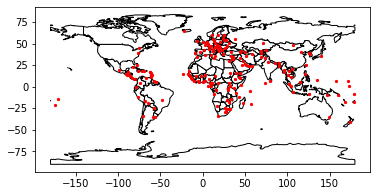

In [101]:
fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

cities.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()

In [90]:
cities.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [91]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [92]:
bodies_gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

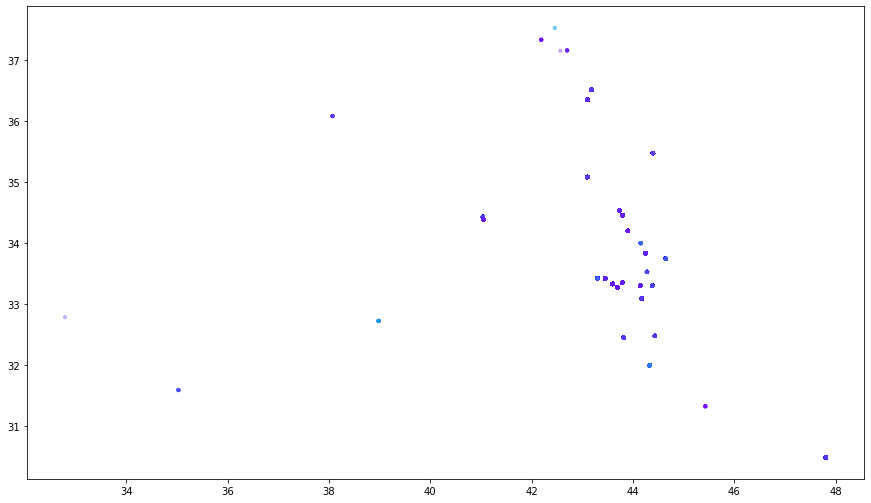

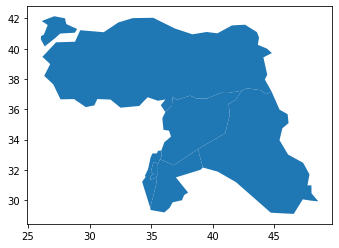

In [68]:
fig, ax = plt.subplots(figsize = (15,15))
sub_world.plot()
bodies_gdf.plot(column = 'person_mean', ax=ax, cmap = 'rainbow', markersize = 10, alpha = 0.3 )

In [ ]:
plt.figure(figsize= [15,15])

x = bodies_df_ll['longitude_full'] + np.random.randn(bodies_df_ll['longitude_full'].shape[0])/12 
y = bodies_df_ll['latitude_full'] + np.random.randn(bodies_df_ll['longitude_full'].shape[0])/12

plt.scatter(x,y, alpha = 0.8, s= 1)
plt.show()

Cut out relevant countirs first

from get_coordinates.ipynd

iraq, Jordan, Palestinian Territory, Syria, Turkey

'Israel', 'Iraq' 'Jordan', 'Syria', 'Turkey


<AxesSubplot:>

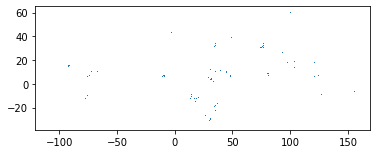

In [58]:
pu_df[pu_df['month_id'] == 121].plot()

In [56]:
# maybe just do a square cutout.
county_mask = ['Israel', 'Iraq', 'Jordan', 'Syria', 'Turkey']
sub_pu_df = pu_df[pu_df['country'].isin(county_mask)].copy()

<AxesSubplot:>

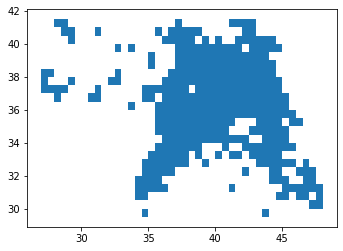

In [57]:
sub_pu_df.plot()

In [31]:
combined_df = gpd.sjoin(bodies_gdf, pu_df, how="right", op='within')

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_113727/3710844654.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  combined_df = gpd.sjoin(bodies_gdf, pu_df, how="right", op='within')


: 

: 

In [1]:
pu_df.csr

NameError: name 'pu_df' is not defined

In [15]:
bodies_gdf = gpd.GeoDataFrame(bodies_df)
bodies_gdf.set_geometry()

1

In [ ]:
geometry = [Point(xy) for xy in zip(bodies_df['longitude_full'], bodies_df['latitude_full'])]

In [22]:
Point(bodies_df[['latitude_full', 'longitude_full']])

KeyError: 0

In [221]:
def elong_df(df, df_w_time, temporal_unit):

    """While a bit hacky, this works. It extents the prio grid to match any temporal unit"""

    t = sorted(df_w_time[temporal_unit].unique())
    df[temporal_unit] = t[0]
    concat_df = df.copy()

    for i,j in enumerate(t[1:]):

        df_temp = df.copy()
        df_temp[temporal_unit] = j

        concat_df = pd.concat([concat_df, df_temp])
    
    concat_df.reset_index(inplace = True)
    return concat_df 

In [222]:
# maybe not the way...
# prio_grid_t = elong_df(prio_grid, ucdp_gid, 'month_id')

KeyboardInterrupt: 

In [ ]:
# maybe not the way...

In [ ]:

def elong_df(df, df_w_years):

    """While a bit hacky, this works. It extents the prio grid to match any temporal unit"""

    years = sorted(df_w_years['year'].unique())
    df['year'] = years[0]
    concat_df = df.copy()

    for i,j in enumerate(years[1:]):

        df_temp = df.copy()
        df_temp['year'] = j

        concat_df = pd.concat([concat_df,df_temp])
    
    concat_df.reset_index(inplace = True)
    return concat_df 


In [ ]:

def make_df(prio_grid, ucdp):

    print('Creating DF...')

    ucdp_gid = trim_ucdp(ucdp=ucdp)
    prio_grid_yearly = elong_df(prio_grid, ucdp_gid)

    grid_ucdp =  pd.merge(prio_grid_yearly, ucdp_gid, how = 'left', on = ['gid', 'year'])
    grid_ucdp.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0}, inplace = True)

    grid_ucdp = grid_ucdp[['gid', 'xcoord', 'ycoord', 'year', 'best', 'low', 'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col.

    grid_ucdpS = grid_ucdp.sort_values(['year', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = grid_ucdp['xcoord'].unique().shape[0]
    y_dim = grid_ucdp['ycoord'].unique().shape[0]
    z_dim = grid_ucdp['year'].unique().shape[0]

    ucpd_vol = np.array(grid_ucdpS).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol